## Image Reconstruction using Random Fourier Features and Linear Regression

This notebook performs image reconstruction by learning a mapping from 2D pixel coordinates (X, Y) to RGB pixel values using:

- **Random Fourier Features (RFF):** To approximate a non-linear RBF kernel and map input coordinates to a high-dimensional space.
- **Linear Regression:** A simple model that learns a linear mapping in the transformed RFF space.




### 1. Image Loading and Preprocessing
- The image is loaded using `torchvision.io.read_image()` as a tensor.
- Pixel values are normalized to the range [0, 1] using `MinMaxScaler`.
- A cropped region of the image is selected to reduce computational load.



###  2. Coordinate Map Creation
- Each pixel is represented by its (x, y) position.
- The function `create_coordinate_map()` pairs every coordinate with its corresponding RGB values.
- This creates training data in the form:  
  **Input:** (x, y) → **Output:** [R, G, B]



###  3. Scaling the Coordinates
- Pixel coordinates are scaled to the range [-1, 1] for better training performance and stability.
- Scaling is done using `MinMaxScaler`.



### 4. Random Fourier Feature (RFF) Transformation
- RFF is used to approximate the RBF (Gaussian) kernel, which captures non-linear patterns.
- The idea is to map the low-dimensional (x, y) coordinates into a higher-dimensional space using cosine transformations.

**RBF Kernel:**

$$
k(x, x') = \exp\left(-\frac{||x - x'||^2}{2\sigma^2} \right)
$$

- This transformation allows a **linear model** to learn complex, non-linear relationships in the data.



###  5. Linear Model Training
- A simple linear regression model (`torch.nn.Linear`) is used to predict RGB values.
- The model is trained using:
  - **Adam optimizer**
  - **Mean Squared Error (MSE) Loss**



###  6. Image Reconstruction and Visualization
- After training, the model predicts RGB values from input coordinates.
- The reconstructed image is reshaped and displayed alongside the original.
- Visual comparison helps judge how well the model has learned.



###  7. Performance Metrics: RMSE and PSNR








In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


### Load the input image using `torchvision`

In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1104, 736])


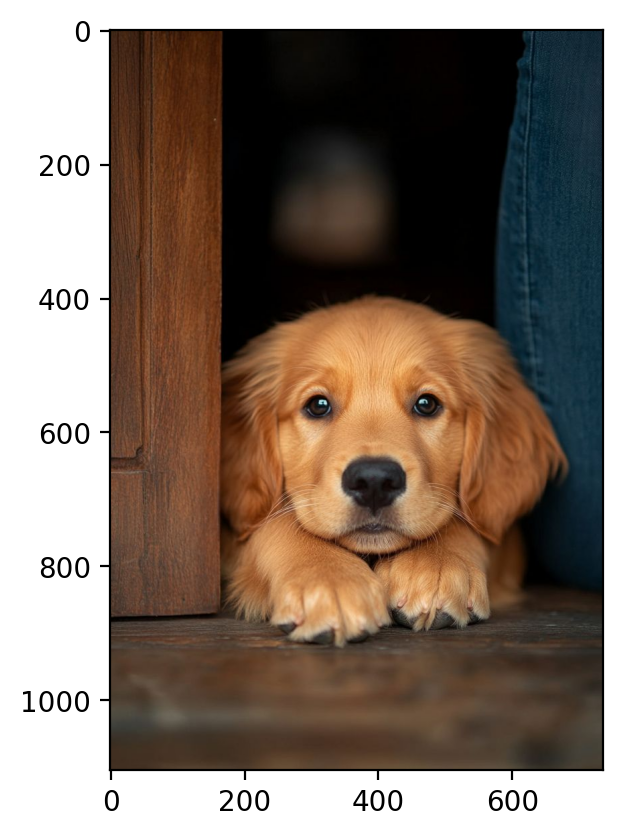

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

### Normalize the pixel values using `MinMaxScaler` to bring them in the [0, 1] range

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

(3, 1104, 736)


tensor([[[0.2118, 0.2000, 0.2157,  ..., 0.1059, 0.0941, 0.0706],
         [0.2118, 0.2078, 0.2275,  ..., 0.1020, 0.0902, 0.0784],
         [0.2039, 0.2118, 0.2392,  ..., 0.0902, 0.0784, 0.0745],
         ...,
         [0.2588, 0.2588, 0.2588,  ..., 0.2706, 0.2706, 0.2706],
         [0.2588, 0.2588, 0.2588,  ..., 0.2706, 0.2706, 0.2706],
         [0.2588, 0.2588, 0.2588,  ..., 0.2667, 0.2667, 0.2667]],

        [[0.1294, 0.1176, 0.1333,  ..., 0.1765, 0.1647, 0.1412],
         [0.1294, 0.1255, 0.1451,  ..., 0.1725, 0.1608, 0.1490],
         [0.1216, 0.1294, 0.1569,  ..., 0.1608, 0.1490, 0.1451],
         ...,
         [0.1882, 0.1882, 0.1882,  ..., 0.2314, 0.2314, 0.2314],
         [0.1882, 0.1882, 0.1882,  ..., 0.2314, 0.2314, 0.2314],
         [0.1882, 0.1882, 0.1882,  ..., 0.2275, 0.2275, 0.2275]],

        [[0.0627, 0.0510, 0.0667,  ..., 0.2314, 0.2196, 0.1961],
         [0.0627, 0.0588, 0.0784,  ..., 0.2275, 0.2157, 0.2039],
         [0.0549, 0.0627, 0.0902,  ..., 0.2157, 0.2039, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 250, 300, 300)
crop.shape

torch.Size([3, 300, 300])

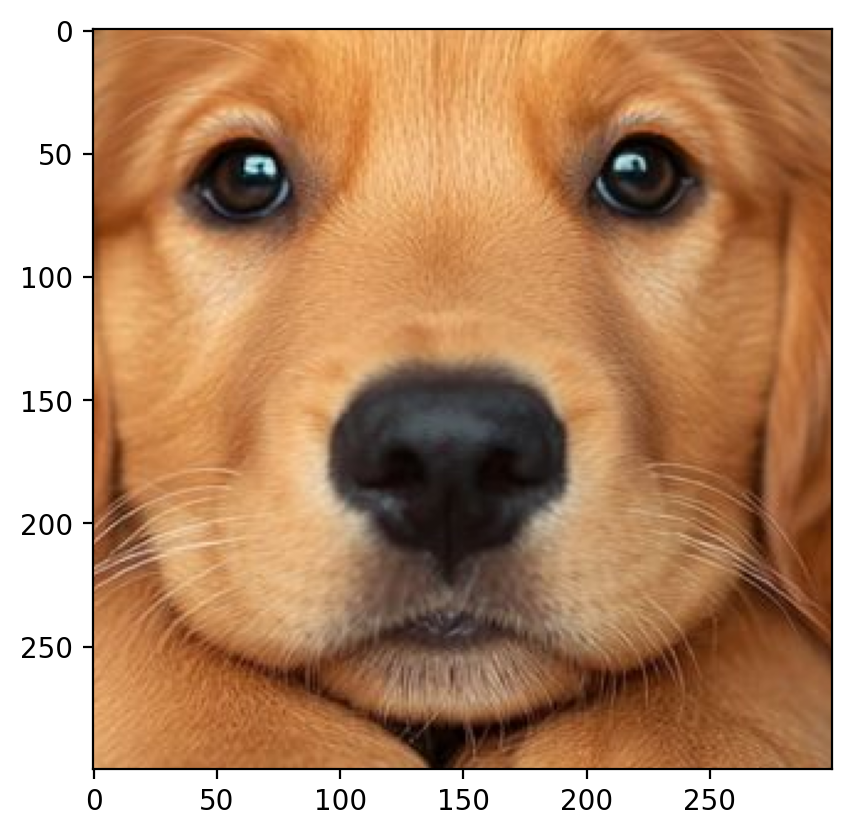

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
crop = crop.to(device)
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)


3 300 300


### Coordinate and Pixel Mapping



In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()



# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()




In [ ]:
net = LinearModel(2, 3)   # without RFF
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.317294
Epoch 100 loss: 0.028707
Epoch 200 loss: 0.028369
Epoch 300 loss: 0.028369
Epoch 400 loss: 0.028369
Epoch 500 loss: 0.028369
Epoch 600 loss: 0.028369
Epoch 700 loss: 0.028369
Epoch 800 loss: 0.028369
Epoch 900 loss: 0.028369


0.028369436040520668

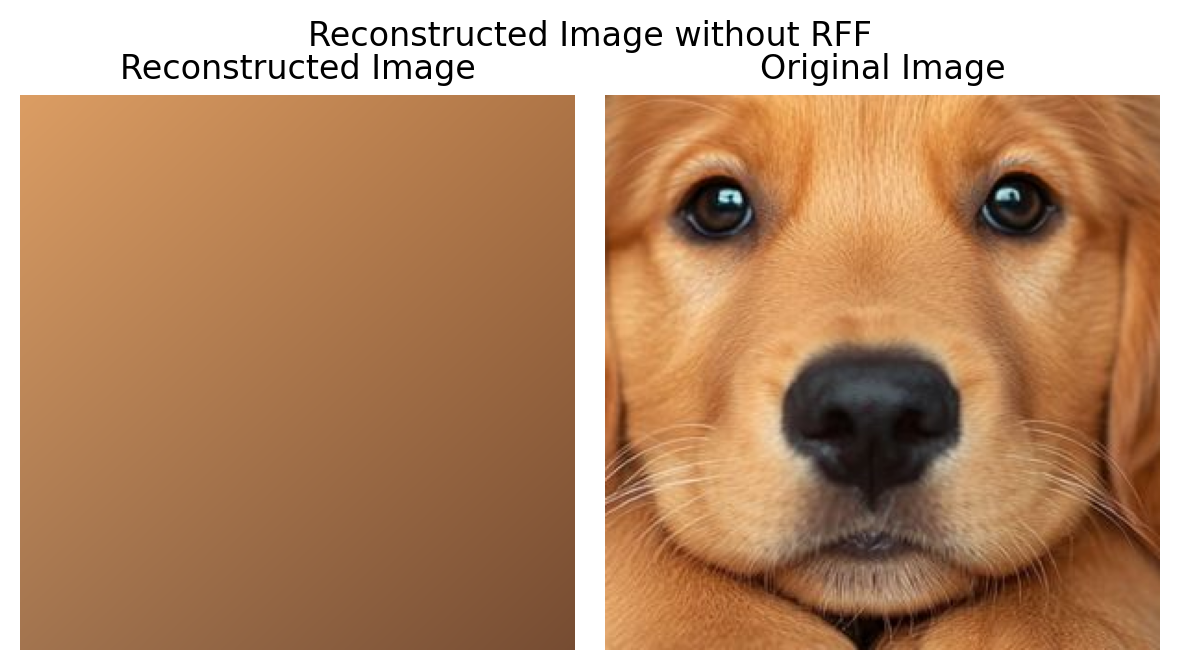

In [ ]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image without RFF")

## Random Fourier Features (RFF)

To handle complex patterns in data, we often use a kernel like the **RBF (Radial Basis Function) kernel**, which captures non-linear relationships. But computing RBF kernels directly can be expensive when the dataset is large.

**Random Fourier Features (RFF)** help us solve this by converting our inputs into a new, higher-dimensional space where a simple linear model can perform well — while still capturing non-linear patterns.




The RBF kernel between two input points **x** and **x′** is given by:

$$
k(x, x') = \exp\left(-\frac{||x - x'||^2}{2\sigma^2}\right)
$$

Here, **σ** (sigma)  is called the kernel width.





Instead of computing the kernel directly, we:

1. Draw **random vectors** `w` from a normal distribution with variance $1/\sigma^2$  
   → $w \sim \mathcal{N}(0, \frac{1}{\sigma^2} I)$  
2. Draw **random biases** `b` from a uniform distribution over $[0, 2\pi]$  
3. Compute the transformed features for each input `x` as:

$$
\phi(x) = \sqrt{\frac{2}{D}} \cdot \cos(w^T x + b)
$$

Where:
- $D$ is the number of random features (higher D → better approximation) and $\phi(x)$ is the new feature vector used as input to a **linear model**










###    

- We used **37,500 random features** for good reconstruction quality and the value of **sigma** is set to `0.008`.
- The `RBFSampler` from `scikit-learn` is used to generate RFF features from the scaled (x, y) coordinates of the image.



In [ ]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff.shape

torch.Size([90000, 37500])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)   # with RFF
net.to(device)

LinearModel(
  (linear): Linear(in_features=37500, out_features=3, bias=True)
)

In [ ]:
train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.279003
Epoch 100 loss: 0.031558
Epoch 200 loss: 0.008365
Epoch 300 loss: 0.004517
Epoch 400 loss: 0.002716
Epoch 500 loss: 0.001708
Epoch 600 loss: 0.001136
Epoch 700 loss: 0.000814
Epoch 800 loss: 0.000635
Epoch 900 loss: 0.000538
Epoch 1000 loss: 0.000487
Epoch 1100 loss: 0.000461
Epoch 1200 loss: 0.000447
Epoch 1300 loss: 0.000440
Epoch 1400 loss: 0.000437
Epoch 1500 loss: 0.000435
Epoch 1600 loss: 0.000434
Epoch 1700 loss: 0.000433
Epoch 1800 loss: 0.000432
Epoch 1900 loss: 0.000431
Epoch 2000 loss: 0.000431
Epoch 2100 loss: 0.000431
Epoch 2200 loss: 0.000430
Epoch 2300 loss: 0.000430
Epoch 2400 loss: 0.000429


0.0004290944489184767

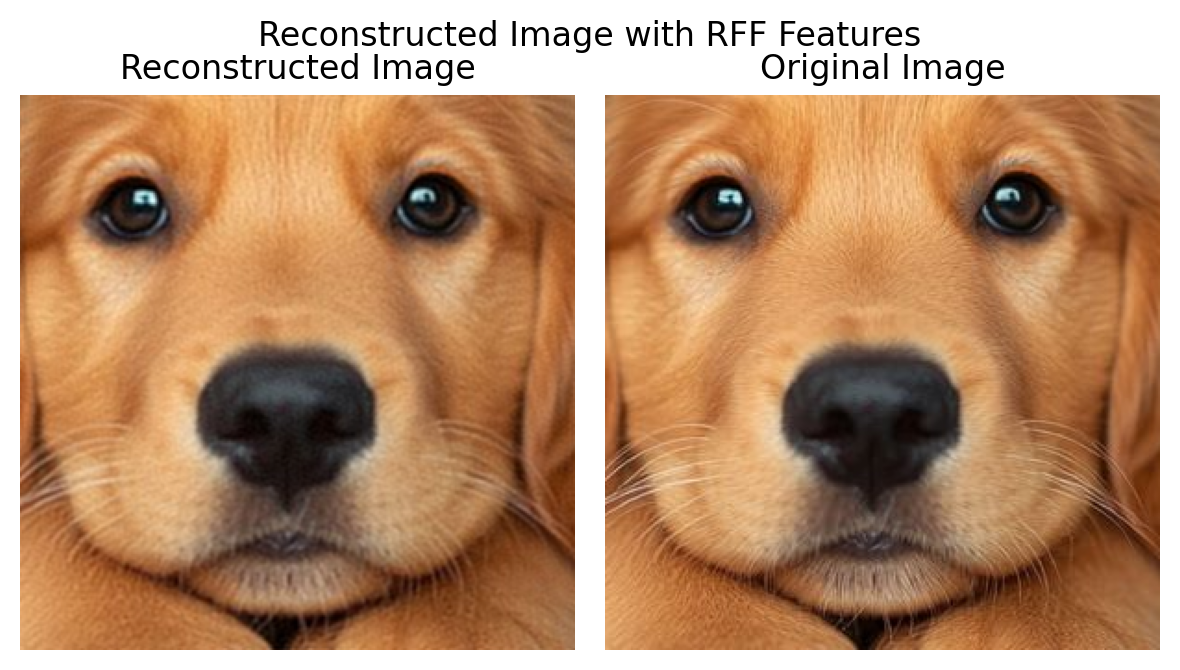

In [ ]:

plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
def reconstructed_and_original_image(original_img, net, X):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    outputs = rearrange(outputs, ' h w c -> c h w ')
    print(outputs.shape)
    return  outputs.cpu(), original_img.cpu()

In [ ]:
# Reconstruct image
reconstructed, original = reconstructed_and_original_image(crop, net, X_rff)

torch.Size([3, 300, 300])


In [ ]:
def print_reconstruction_metrics(original_img, reconstructed_img, title="Reconstruction Metrics"):
    """
    Computes and prints RMSE and PSNR between the original and reconstructed images.

    Parameters:
        original_img (torch.Tensor): Shape [3, H, W], original image
        reconstructed_img (torch.Tensor): Shape [3, H, W], reconstructed image
        title (str): Optional title for output
    """

    # Convert to numpy arrays and reshape to (H, W, C)
    original_np = original_img.permute(1, 2, 0).cpu().numpy() * 255.0
    reconstructed_np = reconstructed_img.permute(1, 2, 0).cpu().numpy() * 255.0

    # Clip values to [0, 255]
    original_np = np.clip(original_np, 0, 255)
    reconstructed_np = np.clip(reconstructed_np, 0, 255)

    # Compute RMSE
    mse = np.mean((original_np - reconstructed_np) ** 2)
    rmse = np.sqrt(mse)

    # Compute PSNR
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255.0 / rmse)

    # Print results
    print(f"{title}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"PSNR: {psnr:.2f} dB")


##  Evaluating Reconstruction Quality: RMSE and PSNR

To check how well our model has reconstructed the image, we use two commonly used evaluation metrics: **Root Mean Square Error (RMSE)** and **Peak Signal-to-Noise Ratio (PSNR)**. These help us measure how close the reconstructed image is to the original one.



###  1. Root Mean Square Error (RMSE)

- **RMSE** tells us the average error between the original image and the reconstructed image.
- It compares each pixel's color value and calculates how far off the reconstruction is, on average.
- The formula is:

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

Where:
- $n$ = total number of pixels
- $y_i$ = pixel value in the original image
- $\hat{y}_i$ = pixel value in the reconstructed image

 **Smaller RMSE means fewer errors**, so the reconstruction is more accurate.


### 2. Peak Signal-to-Noise Ratio (PSNR)

- **PSNR** tells us how clean the reconstructed image is by comparing it to the original.
- It uses the RMSE and the highest possible pixel value (usually 255 for standard images).
- The formula is:

$$
\text{PSNR} = 20 \cdot \log_{10}\left( \frac{255}{\text{RMSE}} \right)
$$



 **Higher PSNR means better quality.**   Values above **30 dB** usually indicate good image reconstruction.






In [ ]:
# Print reconstruction quality
print_reconstruction_metrics(original, reconstructed, title="Reconstruction Metrics")

Reconstruction Metrics:
RMSE: 5.2803
PSNR: 33.68 dB




The model gave an **RMSE of 5.28** and a **PSNR of 33.68 dB**. This means the reconstructed image is quite close to the original one. A low RMSE means the error is small, and a PSNR above 30 dB usually means the image quality is good. So, our method using RFF and linear regression worked well for image reconstruction.
